# Modelling

## **Import all files**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import itertools
import time
import statsmodels.api as sm


from statsmodels.formula.api import ols
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, ElasticNetCV, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from scipy.interpolate import LSQUnivariateSpline, make_smoothing_spline
from patsy import dmatrix

In [ ]:
np.random.seed(37)

## **Function:**

Computing Test Error

In [ ]:
def test_error(predict_y, actual_y):
    return np.mean((predict_y - actual_y) ** 2)

Visualise model performance

In [ ]:
def visualisation(predict_y, actual_y):
    # Create a DataFrame to compare actual vs predicted values
    results_df = pd.DataFrame({'Actual': actual_y, 'Predicted': predict_y})

    # Scatter plot of actual vs predicted values
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x='Actual', y='Predicted', data=results_df, color='blue', alpha=0.6)
    plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
             [results_df['Actual'].min(), results_df['Actual'].max()], color='red', linestyle='--')
    plt.title('Prediction vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid()
    plt.show()

    # Residuals plot
    residuals = actual_y - predict_y
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=predict_y, y=residuals, color='blue', alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid()
    plt.show()

*Only use this one to evaluate model performance*

In [ ]:
def eva_model(model, test_data, predictors, response='DurationSecs'):
    predictions = model.predict(test_data[predictors])

    # Test error
    t_e = test_error(predictions, test_data[response])
    print(f'Test Error: {t_e.round(4)}')

    # R^2
    r2 = r2_score(test_data[response], predictions)
    print(f'R^2: {r2}')

    #Adjusted R^2
    n = len(test_data)  # number of observations
    p = len(predictors)  # number of predictors
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f'Adjusted R^2: {adjusted_r2:.4f}')

    # Visualization
    visualisation(predictions, test_data[response])

## **Initialisation of Dataset**

In [ ]:
ptb_data = pd.read_csv('ptb_data.csv')

In [ ]:
Q1 = ptb_data['DurationSecs'].quantile(0.25)
Q3 = ptb_data['DurationSecs'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
ptb_data = ptb_data[(ptb_data['DurationSecs'] >= lower_bound) & (ptb_data['DurationSecs'] <= upper_bound)]

In [ ]:
df_encoded = ptb_data.drop(columns = ['PTB Defence', 'Anonymize 1PlayerId', 'EventName','PTB Tackle Result',
                                         'Away Score',  'Home Score', 'MatchId', 'OppPossessionSecs', 'PTB Ultimate Outcome',
                                      'OppScore','Player Id', 'SeqNumber', 'Set', 'TotalPossessionSecs', 'Tackle', 'ElapsedTime',
                                      'ZonePhysical','OfficialId','PositionId'])

df_encoded.columns = df_encoded.columns.str.replace('Raw Tackle Number', 'Raw_Tackle_Number')
df_encoded.columns = df_encoded.columns.str.replace('Club Id', 'Club_Id')
df_encoded.columns = df_encoded.columns.str.replace('Opposition Id', 'Opposition_Id')
df_encoded.columns = df_encoded.columns.str.replace('PTB Contest', 'PTB_Contest')
df_encoded.columns = df_encoded.columns.str.replace('Set Type', 'Set_Type')
df_encoded.columns = df_encoded.columns.str.replace('Total Involved Tacklers', 'Total_Involved_Tacklers')


df_encoded = pd.get_dummies(df_encoded, columns=['WeatherConditionName','Raw_Tackle_Number','Half','PTB_Contest','Club_Id',
                                                 'Opposition_Id','SeasonId'], drop_first=True)

df_encoded = df_encoded.dropna()

df_encoded[df_encoded.select_dtypes(include=['bool']).columns] = df_encoded.select_dtypes(include=['bool']).astype(int)

df_encoded.info()

df_encoded.to_csv('encoded_ptb_data.csv', index=False)

# Need to finalise - what variables are numerical - for standardisation purposes.
num_var = ['PossessionSecs',  'Score',  'CurrentMargin','Total_Involved_Tacklers','GameTime']


<class 'pandas.core.frame.DataFrame'>
Index: 109805 entries, 0 to 112026
Data columns (total 62 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   DurationSecs                                       109805 non-null  float64
 1   PossessionSecs                                     109805 non-null  float64
 2   Set_Type                                           109805 non-null  int64  
 3   Total_Involved_Tacklers                            109805 non-null  float64
 4   RoundId                                            109805 non-null  int64  
 5   RunOn                                              109805 non-null  int64  
 6   Score                                              109805 non-null  float64
 7   ZonePossession                                     109805 non-null  int64  
 8   GameTime                                           109805 non-null  float64
 9 

In [ ]:
df_encoded.describe()

,DurationSecs,PossessionSecs,Set_Type,Total_Involved_Tacklers,RoundId,RunOn,Score,ZonePossession,GameTime,IsHome,...,Opposition_Id_b53920c88e4eebf2faa9f4fb43b8944a,Opposition_Id_c03196722c1a837b39f79f1714db475d,Opposition_Id_c14e0139ad91a9741a5731a596aa6549,Opposition_Id_d3ac47d424b41fd738ec9500dbda2d59,Opposition_Id_dc3c7bd8148814b7c4105841baa68e23,Opposition_Id_f38f7f087f646c38c0207f1b2af32f12,Opposition_Id_fdfcde48e2cbf12cc4710a2644b86d85,SeasonId_2021,SeasonId_2022,SeasonId_2023
count,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000,...,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000,109805.000000
mean,3.480552,819.785581,0.251182,2.283976,14.123446,0.827203,10.428368,40.980165,19.122852,0.507500,...,0.064706,0.060908,0.055626,0.061609,0.064587,0.063777,0.057493,0.244661,0.268631,0.270416
std,0.962334,490.360326,0.433695,0.726840,7.082272,0.378074,9.945886,18.766464,11.681113,0.499946,...,0.246007,0.239163,0.229199,0.240446,0.245797,0.244356,0.232783,0.429888,0.443249,0.444177
min,0.760000,5.120000,0.000000,1.000000,3.000000,0.000000,0.000000,8.000000,0.150000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.800000,397.080000,0.000000,2.000000,8.000000,1.000000,0.000000,25.000000,8.916667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.440000,806.840000,0.000000,2.000000,14.000000,1.000000,8.000000,38.000000,18.900000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.120000,1221.480000,1.000000,3.000000,20.000000,1.000000,16.000000,55.000000,29.183333,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6.200000,2393.200000,1.000000,5.000000,29.000000,1.000000,70.000000,77.000000,40.083333,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
Y = df_encoded['DurationSecs']
X = df_encoded.drop(['DurationSecs'],axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109805 entries, 0 to 112026
Data columns (total 61 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   PossessionSecs                                     109805 non-null  float64
 1   Set_Type                                           109805 non-null  int64  
 2   Total_Involved_Tacklers                            109805 non-null  float64
 3   RoundId                                            109805 non-null  int64  
 4   RunOn                                              109805 non-null  int64  
 5   Score                                              109805 non-null  float64
 6   ZonePossession                                     109805 non-null  int64  
 7   GameTime                                           109805 non-null  float64
 8   IsHome                                             109805 non-null  int64  
 9 

## **Set train and test sets**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=37)

## **Regularisation - Involving Lasso, Ridge and Elastic Net**

## **Standardisation**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[num_var] = scaler.fit_transform(X_train[num_var])
X_test[num_var] = scaler.transform(X_test[num_var])

In [ ]:
X_train[num_var].mean().head()

,0
PossessionSecs,2.788980e-16
Score,-1.058000e-16
CurrentMargin,1.294190e-18
Total_Involved_Tacklers,-8.946089e-17
GameTime,3.458723e-16


In [ ]:
X_train[num_var].std().head()

,0
PossessionSecs,1.000006
Score,1.000006
CurrentMargin,1.000006
Total_Involved_Tacklers,1.000006
GameTime,1.000006


## **Lasso**

In [ ]:
# Fit the LassoCV model
lasso = LassoCV(cv=5)
lasso.fit(X_train, np.ravel(Y_train))
print(f'LASSO Lambda: {lasso.alpha_}')

LASSO Lambda: 0.0009714873348748116


In [ ]:
# Create a DataFrame for LASSO coefficients
lasso_coefficients = pd.DataFrame(
    [lasso.intercept_.round(10)] + list(lasso.coef_.round(10)),
    index=['Intercept'] + X.columns.tolist(),
    columns=['Coefficient']
)

# Display all rows of the DataFrame
pd.options.display.max_rows = None
print(lasso_coefficients)

# Reset display option if needed
# pd.reset_option('display.max_rows')


                                                   Coefficient
Intercept                                             3.726976
PossessionSecs                                        0.025040
Set_Type                                              0.177140
Total_Involved_Tacklers                               0.052206
RoundId                                              -0.002044
RunOn                                                 0.092324
Score                                                 0.022605
ZonePossession                                        0.003772
GameTime                                              0.026926
IsHome                                               -0.020581
CurrentMargin                                         0.015904
WeatherConditionName_Rain                             0.036077
WeatherConditionName_Showers                          0.000000
WeatherConditionName_Snow                            -0.000000
WeatherConditionName_Unknown                          0

Test Error: 0.7265
R^2: 0.2261723721987955
Adjusted R^2: 0.2240


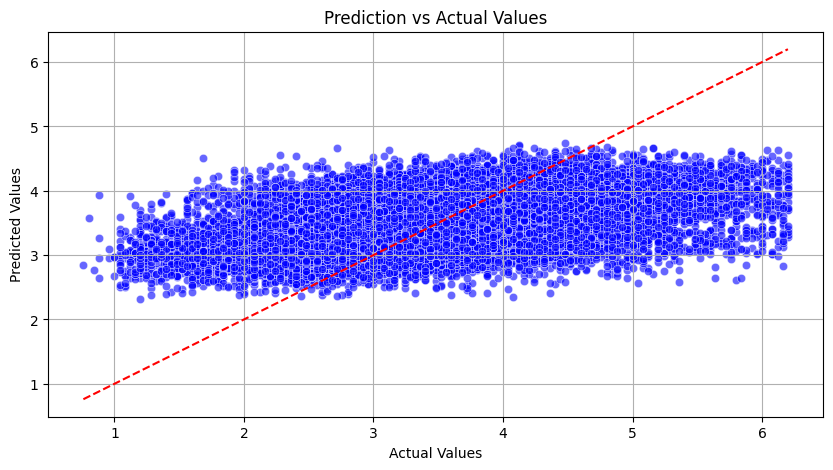

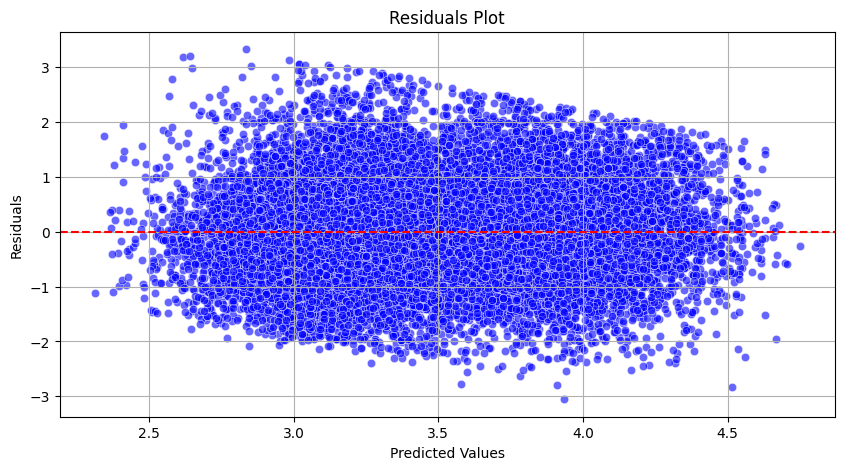

In [ ]:
# Evaluate the model
eva_model(model=lasso, test_data=X_test.assign(DurationSecs=Y_test), predictors=X.columns.tolist(), response='DurationSecs')

In [ ]:
# Predict on the test set
Y_pred = lasso.predict(X_test)

# Calculate MSE
mse = mean_squared_error(Y_test, Y_pred)

# Print the MSE
print(f'Test Set MSE: {mse}')

Test Set MSE: 0.7265187031603071


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Perform 5-fold cross-validation
cv_scores = cross_val_score(
    lasso,
    X_train,
    Y_train,
    cv=5,
    scoring='neg_mean_squared_error'
)

# Convert negative MSE to RMSE
cv_rmse = np.sqrt(-cv_scores)

# Calculate average RMSE across folds
mean_cv_rmse = np.mean(cv_rmse)

# Display results
print("Cross-Validation RMSE for each fold:", cv_rmse)
print(f"Average 5-Fold CV RMSE: {mean_cv_rmse}")


Cross-Validation RMSE for each fold: [0.84895677 0.85158854 0.85277328 0.85229755 0.84794807]
Average 5-Fold CV RMSE: 0.8507128412533381
